# Regime-Adaptive Algorithmic Trading Strategy
## Hidden Markov Model + Random Forest

---

This notebook implements a regime-adaptive trading strategy that combines:
- **Hidden Markov Models (HMM)** to detect latent market regimes (e.g. bull/bear/sideways)
- **Regime-specific Random Forest classifiers** to predict directional price moves within each regime

The core idea is that financial markets behave differently across time. A single model trained on all market conditions will underperform compared to specialized models that are aware of the current regime.

### Pipeline Overview
```
Raw OHLCV Data
     ↓
Technical Feature Engineering (stationarity-checked)
     ↓
HMM → Regime Labels (0 or 1)
     ↓
Regime-Specific Random Forest → Directional Signal
     ↓
Walk-Forward Backtest → Performance Evaluation
```

### Reference
Based on: [Regime-Adaptive Trading with Python – QuantInsti Blog](https://blog.quantinsti.com/regime-adaptive-trading-python/)

---
## 1. Imports

Key dependencies:
- `hmmlearn`: Gaussian HMM training and inference
- `ta`: 130+ technical analysis indicators
- `sklearn`: Random Forest classifier
- `quantstats`: Performance statistics and reporting
- `statsmodels`: Augmented Dickey-Fuller stationarity test

> **Windows note**: the KMeans memory-leak warning from sklearn is a known Windows/MKL bug unrelated to this strategy. We suppress it via `warnings.filterwarnings`.

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Suppress KMeans/MKL Windows warning and other noise

import os
os.environ['OMP_NUM_THREADS'] = '1'  # Fix KMeans memory leak on Windows with MKL

# Import the pandas library for data manipulation and analysis
import pandas as pd
# Import the numpy library for numerical operations
import numpy as np
# Import the matplotlib.pyplot library for plotting
import matplotlib.pyplot as plt
# Import the yfinance library to download financial data
import yfinance as yf
# Import the ta library for technical analysis indicators
try:
    from ta import add_all_ta_features
except ImportError:
    import sys
    !{sys.executable} -m pip install ta
    from ta import add_all_ta_features
# Import the RandomForestClassifier from scikit-learn for building random forest models
from sklearn.ensemble import RandomForestClassifier
# Import the hmm module from hmmlearn for Hidden Markov Models
try:
    from hmmlearn import hmm
except ImportError:
    import sys
    !{sys.executable} -m pip install hmmlearn
    from hmmlearn import hmm
# Import the adfuller function from statsmodels for the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
# Import the datetime module to work with dates
import datetime
# Import quantstats for strategy performance metrics
try:
    import quantstats as qs
except ImportError:
    import sys
    !{sys.executable} -m pip install quantstats
    import quantstats as qs

print("All libraries imported successfully.")

All libraries imported successfully.


---
## 2. Data Download

We use `yfinance` to pull adjusted OHLCV data for any ticker. Daily percentage returns are computed immediately as the core observation series for the HMM.

In [2]:
# Define a function to download and prepare stock data
def get_data(ticker, start_date, end_date):
    """Downloads adjusted OHLCV data and computes daily returns."""
    # Download historical stock data from Yahoo Finance using yfinance
    # auto_adjust=True ensures prices are adjusted for splits and dividends
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, group_by='ticker')[ticker]
    # Calculate daily percentage returns and store them in a new 'returns' column
    # pct_change() computes (P_t - P_{t-1}) / P_{t-1} for each row
    data['returns'] = data['Close'].pct_change()
    # Return the DataFrame containing OHLCV data plus the computed returns
    return data

# --- Parameters ---
# Ticker symbol to trade (change to 'SPY', 'AAPL', 'GLD', etc. for other assets)
TICKER = 'BTC-USD'
# Start date for the full data download (needs enough history for the 4-year rolling window)
START_DATE = '2008-01-01'
# End date for the full data download
END_DATE = '2025-06-18'
# Date from which trading signals are generated (requires 4 years of prior data)
BACKTEST_SIGNAL_START_DATE = '2024-01-01'
# Number of days ahead to predict (1 = next-day prediction)
NUM_LEAD = 1

# --- Execute ---
# Download and prepare the raw historical data for the chosen ticker
raw_data = get_data(TICKER, START_DATE, END_DATE)

# Print a summary of the downloaded data
print(f'Downloaded {len(raw_data)} rows for {TICKER}')
print(f'Date range: {raw_data.index[0].date()} -> {raw_data.index[-1].date()}')
# Display the last 5 rows to verify the data looks correct
raw_data.tail()

[*********************100%***********************]  1 of 1 completed

Downloaded 3927 rows for BTC-USD
Date range: 2014-09-17 -> 2025-06-17


Price,Open,High,Low,Close,Volume,returns
Date,,,,,,
2025-06-13,105924.593750,106182.546875,102822.023438,106090.968750,69550440846,0.001529
2025-06-14,106108.085938,106203.757812,104379.367188,105472.406250,38007870453,-0.005830
2025-06-15,105464.843750,106157.101562,104519.882812,105552.023438,36744307742,0.000755
2025-06-16,105555.593750,108915.375000,104997.625000,106796.757812,50366626945,0.011793
2025-06-17,106794.117188,107750.195312,103396.531250,104601.117188,55964092176,-0.020559


---
## 3. Feature Engineering

This is one of the most critical steps. We generate the full suite of technical indicators using `ta`, then apply a **stationarity filter** via the Augmented Dickey-Fuller (ADF) test.

### Why stationarity matters
Most ML models assume that the statistical properties of features do not change over time. Non-stationary series (e.g. raw price levels, cumulative volume) will cause the model to learn spurious patterns. The ADF test checks for a **unit root** — if the p-value is above 0.05, the series is likely non-stationary and we transform it via percentage change.

### Target variable
We define `y_signal` as a binary label:
- `1` if the return `num_lead` days ahead is positive
- `0` otherwise

The `num_lead` parameter controls the prediction horizon (typically 1 day).

In [4]:
# Define a function to engineer technical features and ensure stationarity
def engineer_features(data_df, num_lead):
    """Engineers technical features from OHLCV data and ensures all features are stationary."""
    # Note: the 'returns' column is expected to be present from the get_data() function

    # Create a new DataFrame with the same index as the input for TA feature calculation
    df_input_for_ta = pd.DataFrame(index=data_df.index)
    # Copy OHLCV columns and cast to float to ensure compatibility with the ta library
    df_input_for_ta['Open']   = data_df['Open'].astype(float)
    df_input_for_ta['High']   = data_df['High'].astype(float)
    df_input_for_ta['Low']    = data_df['Low'].astype(float)
    df_input_for_ta['Close']  = data_df['Close'].astype(float)
    df_input_for_ta['Volume'] = data_df['Volume'].astype(float)

    # Add all technical analysis features using the 'ta' library
    # fillna=True forward-fills NaN values created by indicator warm-up periods
    features_added_df = add_all_ta_features(
        df_input_for_ta, open='Open', high='High', low='Low',
        close='Close', volume='Volume', fillna=True
    )

    # Define a list of the original OHLCV columns to remove from the TA features DataFrame
    # We only want the derived indicators, not the raw price data
    columns_to_drop_from_ta_output = ['Open', 'High', 'Low', 'Close', 'Volume']
    # Drop the original OHLCV columns to keep only the TA indicator features
    processed_features_df = features_added_df.drop(
        columns=columns_to_drop_from_ta_output, errors='ignore'
    )

    # Initialize lists to categorize indicators based on the ADF stationarity test results
    indicators_to_become_stationary = []
    # List for indicators that must be dropped entirely (insufficient data or NaN p-values)
    indicators_to_drop = []

    # Loop through each indicator column to check for stationarity
    for indicator in processed_features_df.columns:
        # Replace infinite values with NaN and drop NaNs for a clean ADF test input
        indicator_series = processed_features_df[indicator].replace([np.inf, -np.inf], np.nan).dropna()

        # Drop indicators with insufficient data points for a reliable ADF test
        if len(indicator_series) < 20:
            indicators_to_drop.append(indicator)
            continue

        # Perform the Augmented Dickey-Fuller test to check for a unit root
        # A unit root implies non-stationarity; regression='c' includes a constant term
        pvalue = adfuller(indicator_series, regression='c', autolag='AIC')[1]

        # If the p-value is above 0.05, we fail to reject the null hypothesis of a unit root
        # i.e. the series is likely non-stationary and needs to be transformed
        if pvalue > 0.05:
            indicators_to_become_stationary.append(indicator)
        # Drop indicators where the ADF test returns NaN (degenerate or constant series)
        elif np.isnan(pvalue):
            indicators_to_drop.append(indicator)

    # Make non-stationary indicators stationary by applying percentage change transformation
    # pct_change() converts price-like levels into return-like differences
    if indicators_to_become_stationary:
        processed_features_df.loc[:, indicators_to_become_stationary] = \
            processed_features_df[indicators_to_become_stationary].pct_change()

    # Drop all indicators that were flagged for removal
    if indicators_to_drop:
        processed_features_df.drop(columns=indicators_to_drop, inplace=True, errors='ignore')

    # Concatenate the original OHLCV + returns DataFrame with the engineered TA features
    data_with_all_features = pd.concat([data_df, processed_features_df], axis=1)

    # Define the binary prediction target 'y_signal':
    # 1 if the return 'num_lead' days ahead is positive, 0 otherwise
    data_with_all_features['y_signal'] = np.where(
        data_with_all_features['returns'].shift(-num_lead) > 0, 1, 0
    )

    # Identify the final list of valid feature column names to pass to the model
    final_feature_columns = [
        col for col in processed_features_df.columns
        if col in data_with_all_features.columns
    ]
    return data_with_all_features, final_feature_columns

# --- Execute ---
# Engineer features from the raw data
data_with_features, feature_cols = engineer_features(raw_data.copy(), NUM_LEAD)

# Print a summary of the feature engineering results
print(f'Number of features after stationarity filter: {len(feature_cols)}')
print(f'Data shape after preprocessing: {data_with_features.shape}')
# Display the last 3 rows of the feature matrix to verify
data_with_features[feature_cols].tail(3)

Number of features after stationarity filter: 86
Data shape after preprocessing: (3927, 93)


,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-15,0.001531,0.017415,0.075545,-7.501255e+12,209.104944,5.013072,0.000182,0.000155,59.280007,0.000755,...,0.722372,1.068421,-0.346050,-0.252475,1.431929,-1.684404,-0.000223,0.075486,0.075458,0.000758
2025-06-16,-0.000655,0.023463,0.078755,2.526506e+12,12585.615698,908.443952,0.003893,0.001142,59.597200,0.000000,...,0.700138,0.994764,-0.294627,0.082310,1.162005,-1.079695,0.000263,1.179262,1.172362,0.011844
2025-06-17,-0.003990,-0.025472,0.062843,-1.538829e+13,-10759.957665,-159.883089,-0.007512,-0.000413,52.135427,0.000000,...,0.509896,0.897791,-0.387895,1.246285,1.178861,0.067424,-0.000158,-2.055906,-2.077334,-0.020647


---
## 4. Walk-Forward Backtest Engine

This is the core of the strategy. We implement a **walk-forward (event-driven) backtest** to avoid lookahead bias.

### How it works

At each time step `t`, the algorithm:
1. Takes the last `window_size` days (4 years) of data as the historical sample
2. Splits it into training data and a recent test buffer (last 90 days)
3. Trains a `GaussianHMM` with 2 components on the training returns to identify regimes
4. Labels every training day with a regime (0 or 1)
5. Trains a **separate Random Forest** for each regime on the regime-labeled days
6. Predicts the next day's regime using the HMM transition matrix: $P(S_{t+1}) = P(S_t) \cdot A$
7. Uses the RF corresponding to the most likely next-day regime to generate a directional signal
8. Thresholds the signal probability: long if $p > 0.53$, short if $p < 0.47$, else flat

### Key design choices
- **Rolling window of 4 years**: balances recency with sufficient training data
- **90-day test buffer**: the most recent data is held out to avoid contaminating the RF training targets
- **Regime-specific models**: each RF specializes on the statistical patterns of one market regime
- **Transition matrix for regime forecasting**: rather than using today's regime to trade, we project one step forward using the Markov transition matrix $A$, where $a_{ij} = P(S_{t+1}=j \mid S_t=i)$

In [5]:
# Define the main walk-forward backtesting function
def run_backtest(data_df, feature_list, backtest_signal_start_date_str, num_lead):
    """Runs the walk-forward event-driven backtest.
    At each time step, retrains HMM + regime-specific RF on a rolling window
    and generates a directional signal for the current day.
    """
    # Define the rolling window size: 4 years of trading days
    window_size = 4 * 252
    # Number of most recent days withheld from RF training to avoid leakage into the target
    train_test_split_days = 90
    # Minimum number of regime-specific samples required to train a Random Forest
    min_samples_for_rf = 30

    # Initialize the 'signal' column to zero (flat / no position) for all dates
    data_df['signal'] = 0.0

    # Convert the backtest start date string to a datetime object for index comparison
    target_signal_start_datetime = pd.to_datetime(backtest_signal_start_date_str)
    # Find all dates in the index that are on or after the target start date
    dates_after_target = data_df.index[data_df.index >= target_signal_start_datetime]

    # Handle the edge case where the start date is after the last available data point
    if dates_after_target.empty:
        print(f'No data on or after {backtest_signal_start_date_str}.')
        return data_df

    # Find the integer location of the first valid backtest date in the DataFrame index
    first_target_date_idx = data_df.index.get_loc(dates_after_target[0])
    # The main loop starts at whichever is later: when we have enough history, or the target start
    loop_start_index = max(window_size, first_target_date_idx)
    print(f'Backtest starting from: {data_df.index[loop_start_index].strftime("%Y-%m-%d")}')

    # Main walk-forward loop: iterate over each trading day in the backtest period
    for t in range(loop_start_index, len(data_df)):
        # Store the current prediction date for labeling the signal
        current_date = data_df.index[t]
        # Extract the rolling historical window ending at (but not including) the current day
        data_sample = data_df.iloc[t - window_size : t].copy()

        # Skip this iteration if the sample is smaller than expected (e.g. at the very start)
        if len(data_sample) < window_size:
            continue

        # Split the historical sample into training data (older) and a recent buffer (newer)
        # The buffer prevents the RF target variable from overlapping with prediction features
        model_training_data = data_sample.iloc[:-train_test_split_days].copy()

        # Ensure there is enough training data to fit both a HMM and at least one RF model
        if len(model_training_data) < (min_samples_for_rf * 2):
            data_df.loc[current_date, 'signal'] = 0.0
            continue

        # --- HMM for Regime Detection ---
        # Initialize the HMM model variable to None before attempting to train
        hmm_model = None
        # Extract only the 'returns' column as the HMM observation sequence and drop NaNs
        hmm_train_features = model_training_data[['returns']].dropna()

        # Train the HMM only if there are enough clean observations
        if len(hmm_train_features) >= min_samples_for_rf:
            # Fit a Gaussian HMM with 2 hidden states (regimes) on the return series
            # covariance_type='diag' assumes independent features (scalar returns here)
            hmm_model = hmm.GaussianHMM(n_components=2, covariance_type='diag',
                                        n_iter=100, random_state=100)
            hmm_model.fit(hmm_train_features)
            # Decode the most likely state sequence using the Viterbi algorithm
            regimes = hmm_model.predict(hmm_train_features)
            # Assign the decoded regime label to each training day for use in RF training
            model_training_data.loc[hmm_train_features.index, 'regime'] = regimes

        # --- Regime-Specific Random Forest Models ---
        # Initialize both regime models to None before attempting to train
        model0, model1 = None, None
        # Only proceed if the HMM successfully labeled the training data with regimes
        if 'regime' in model_training_data.columns and feature_list:
            # Split the training data into two subsets, one per regime
            r0 = model_training_data[model_training_data['regime'] == 0]
            r1 = model_training_data[model_training_data['regime'] == 1]

            # Train Model for Regime 0 only if there are enough samples and both classes present
            if len(r0) >= min_samples_for_rf and len(r0['y_signal'].unique()) > 1:
                # Exclude the last 'num_lead' rows to avoid look-ahead bias in the target
                model0 = RandomForestClassifier(n_estimators=50, random_state=100)
                model0.fit(r0[feature_list].iloc[:-num_lead], r0['y_signal'].iloc[:-num_lead])

            # Train Model for Regime 1 only if there are enough samples and both classes present
            if len(r1) >= min_samples_for_rf and len(r1['y_signal'].unique()) > 1:
                # Exclude the last 'num_lead' rows to avoid look-ahead bias in the target
                model1 = RandomForestClassifier(n_estimators=50, random_state=100)
                model1.fit(r1[feature_list].iloc[:-num_lead], r1['y_signal'].iloc[:-num_lead])

        # --- Prediction for the Current Day ---
        # Extract the feature row(s) for the current prediction day
        features_pred     = data_sample[feature_list].iloc[-num_lead:].copy() if feature_list else pd.DataFrame()
        # Extract the return observation for the current day to query the HMM
        hmm_features_pred = data_sample[['returns']].iloc[-1:].copy()
        # Default to equal probability for each regime if HMM is unavailable
        next_day_probs = np.array([0.5, 0.5])

        # Predict next day's regime probabilities using the HMM transition matrix
        # P(S_{t+1}) = P(S_t) @ A, where A is the learned transition matrix
        if hmm_model and not hmm_features_pred.isnull().values.any():
            # Get the smoothed state probability distribution for the current day
            last_probs     = hmm_model.predict_proba(hmm_features_pred)[0]
            # Project one step forward using the transition matrix
            next_day_probs = last_probs @ hmm_model.transmat_

        # Initialize signals from both regime models to neutral
        signal0, signal1 = 0.0, 0.0
        # Check that the feature row for today is free of NaNs and infinities before predicting
        clean = (not features_pred.empty and
                 not features_pred.isnull().values.any() and
                 not np.isinf(features_pred.values).any())

        # Generate probability-of-up-move from each regime's Random Forest
        if model0 and clean:
            # predict_proba returns [P(down), P(up)]; we take the probability of an up move
            signal0 = model0.predict_proba(features_pred)[0][1]
        if model1 and clean:
            signal1 = model1.predict_proba(features_pred)[0][1]

        # Select the signal from the regime most likely to occur tomorrow
        if next_day_probs[0] > next_day_probs[1]:
            final_signal = signal0
        elif next_day_probs[1] > next_day_probs[0]:
            final_signal = signal1
        else:
            # If both regimes are equally likely, stay flat
            final_signal = 0.0

        # Apply a confidence threshold around 0.5 as a risk management filter:
        # go long (+1) only if sufficiently bullish, short (-1) if sufficiently bearish, else flat
        limit = 0.03
        data_df.loc[current_date, 'signal'] = (
            1  if final_signal > (0.5 + limit) else
            -1 if final_signal < (0.5 - limit) else
            0
        )

        # Print progress every 100 iterations to monitor the backtest
        if t % 100 == 0:
            print(f'  {current_date.strftime("%Y-%m-%d")}  signal_prob={final_signal:.3f}')

    return data_df

# --- Execute (may take several minutes) ---
# Run the walk-forward backtest over the specified signal generation period
print('Running walk-forward backtest...')
results_df = run_backtest(data_with_features.copy(), feature_cols, BACKTEST_SIGNAL_START_DATE, NUM_LEAD)
print('Backtest complete.')

Running walk-forward backtest...
Backtest starting from: 2024-01-01
  2024-01-08  signal_prob=0.500
  2024-04-17  signal_prob=0.460
  2024-07-26  signal_prob=0.460
  2024-11-03  signal_prob=0.560
  2025-02-11  signal_prob=0.620
  2025-05-22  signal_prob=0.660
Backtest complete.


---
## 5. Results Visualization

We plot the cumulative returns of the HMM-RF strategy against a passive Buy-and-Hold benchmark. The strategy return at each step is:

$$r^{\text{strategy}}_t = r_t \times \text{signal}_{t-1}$$

where `signal` $\in \{-1, 0, 1\}$.

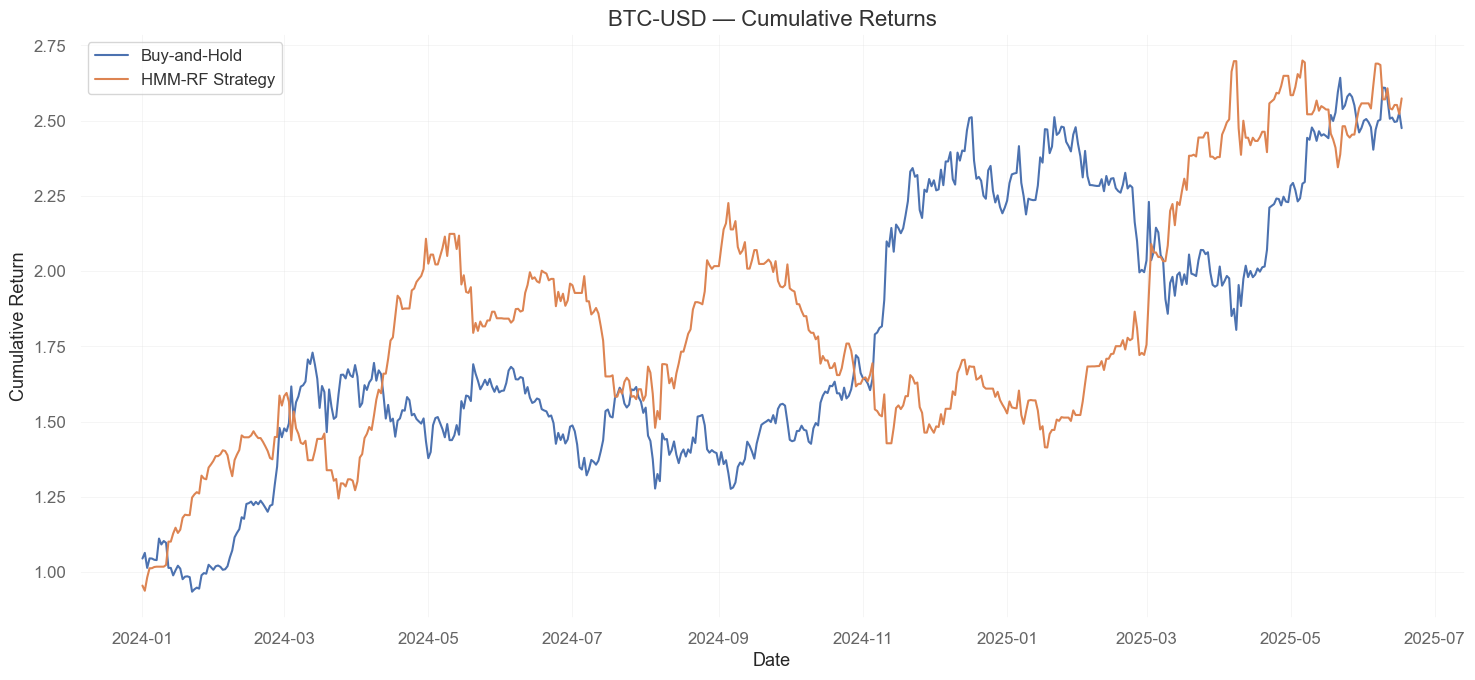

In [6]:
# Define a function to plot the backtesting results
def plot_results(results_df, ticker):
    """Plots cumulative returns of the HMM-RF strategy versus a Buy-and-Hold benchmark."""
    # Check if the results DataFrame is empty before attempting to plot
    if results_df.empty:
        print(f'No results to plot for {ticker}.')
        return results_df

    # Work on a copy to avoid modifying the original DataFrame
    df = results_df.copy()

    # Calculate cumulative returns for a passive Buy-and-Hold strategy
    # cumprod() of (1 + r) gives the growth of $1 invested at the start
    df['bh_cum_rets'] = (1 + df['returns']).cumprod()
    # Calculate strategy daily returns by multiplying market returns by the lagged signal
    # signal in {-1, 0, 1}: short, flat, or long the asset each day
    df['strategy_returns'] = df['returns'] * df['signal']
    # Drop rows where strategy returns are NaN (typically the first few days without a signal)
    df.dropna(subset=['strategy_returns'], inplace=True)

    # Check if there are any valid strategy returns left after dropping NaNs
    if df.empty or df['strategy_returns'].isnull().all():
        print('No valid strategy returns to plot after processing.')
        return df

    # Calculate cumulative returns for the HMM-RF strategy
    df['strategy_cum_rets'] = (1 + df['strategy_returns']).cumprod()

    # Create the comparison plot
    fig, ax = plt.subplots(figsize=(15, 7))
    # Plot the Buy-and-Hold cumulative return curve
    ax.plot(df.index, df['bh_cum_rets'],       label='Buy-and-Hold', linewidth=1.5)
    # Plot the HMM-RF strategy cumulative return curve
    ax.plot(df.index, df['strategy_cum_rets'], label='HMM-RF Strategy', linewidth=1.5)
    # Set chart title and axis labels
    ax.set_title(f'{ticker} — Cumulative Returns', fontsize=16)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Cumulative Return', fontsize=13)
    # Add legend and grid for readability
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

    # Return the DataFrame with the computed return columns attached
    return df

# --- Execute ---
# Filter the results DataFrame to the backtest signal period for plotting
results_to_plot = results_df[results_df.index >= pd.to_datetime(BACKTEST_SIGNAL_START_DATE)].copy()
# Plot cumulative returns and store the enriched DataFrame (now contains strategy_returns)
results_to_plot = plot_results(results_to_plot, TICKER)

---
## 6. Performance Statistics

We use `quantstats` to compute industry-standard performance metrics and compare the strategy against Buy-and-Hold:

| Metric | Description |
|--------|-------------|
| Annual Return | Annualized geometric mean return |
| Cumulative Returns | Total return over the period |
| Annual Volatility | Annualized standard deviation of returns |
| Sharpe Ratio | Risk-adjusted return (excess return / volatility) |
| Calmar Ratio | Annual return / Max drawdown |
| Max Drawdown | Largest peak-to-trough decline |
| Sortino Ratio | Like Sharpe but penalizes only downside volatility |

In [7]:
# Define a function to compute and display performance statistics
def compute_perf_stats(results_to_plot):
    """Computes and prints a side-by-side performance comparison using quantstats."""
    # Extract the daily strategy returns and drop any NaN values
    strategy_returns = results_to_plot['strategy_returns'].dropna()
    # Extract the raw market returns for the Buy-and-Hold benchmark
    bh_returns       = results_to_plot['returns'].dropna()

    # Compute each performance metric for both the strategy and the benchmark
    metrics = {
        # Compound Annual Growth Rate: annualized geometric mean return
        'Annual return':      (qs.stats.cagr(strategy_returns),         qs.stats.cagr(bh_returns)),
        # Total compounded return over the full backtest period
        'Cumulative returns': (qs.stats.comp(strategy_returns),         qs.stats.comp(bh_returns)),
        # Annualized standard deviation of daily returns
        'Annual volatility':  (qs.stats.volatility(strategy_returns),   qs.stats.volatility(bh_returns)),
        # Sharpe ratio: excess return per unit of total risk (annualized)
        'Sharpe ratio':       (qs.stats.sharpe(strategy_returns),       qs.stats.sharpe(bh_returns)),
        # Calmar ratio: annual return divided by maximum drawdown
        'Calmar ratio':       (qs.stats.calmar(strategy_returns),       qs.stats.calmar(bh_returns)),
        # Maximum drawdown: largest peak-to-trough decline in cumulative returns
        'Max drawdown':       (qs.stats.max_drawdown(strategy_returns), qs.stats.max_drawdown(bh_returns)),
        # Sortino ratio: like Sharpe but penalizes only downside volatility
        'Sortino ratio':      (qs.stats.sortino(strategy_returns),      qs.stats.sortino(bh_returns)),
    }

    # Define which metrics should be displayed as percentages
    pct_metrics = {'Annual return', 'Cumulative returns', 'Annual volatility', 'Max drawdown'}

    # Build the rows of the output table, formatting values appropriately
    rows = []
    for name, (strat_val, bh_val) in metrics.items():
        if name in pct_metrics:
            # Format as percentage with two decimal places
            rows.append({'Metric': name,
                         'Strategy':   f'{strat_val * 100:.2f}%',
                         'Buy & Hold': f'{bh_val   * 100:.2f}%'})
        else:
            # Format as a plain float with two decimal places
            rows.append({'Metric': name,
                         'Strategy':   f'{strat_val:.2f}',
                         'Buy & Hold': f'{bh_val:.2f}'})

    # Assemble the rows into a DataFrame and set 'Metric' as the index for clean display
    final_table = pd.DataFrame(rows).set_index('Metric')
    # Print the formatted comparison table
    print(final_table)
    return final_table

# --- Execute ---
# Compute and display the performance statistics for strategy vs Buy-and-Hold
perf_table = compute_perf_stats(results_to_plot)

                   Strategy Buy & Hold
Metric                                
Annual return        56.22%     53.36%
Cumulative returns  157.37%    147.49%
Annual volatility    38.99%     43.16%
Sharpe ratio           1.34       1.21
Calmar ratio           1.54       1.90
Max drawdown        -36.49%    -28.14%
Sortino ratio          2.00       1.91


---
## 7. Results & Next Steps

The results look promising because the strategy returns have **lower volatility** than the buy-and-hold returns. Although this is just a sample, it illustrates the value of regime-awareness: by switching between specialized models, the strategy avoids taking large directional bets during uncertain market conditions.

### Things you can do to improve the results

- **Add more input features**: the current feature set relies entirely on price and volume-derived technical indicators. Incorporating macroeconomic variables (VIX, yield spreads, sentiment indices) or alternative data could improve the regime separation and the RF signal quality.

- **Add risk-management thresholds**: the current `limit = 0.03` filter is a simple fixed threshold. A more sophisticated approach would dynamically adjust position sizing based on the confidence of the regime prediction or on realized volatility.

- **Synthetic data augmentation per regime**: instead of training the RF only on the historically observed regime-specific samples (which can be small), you can generate multiple synthetic return paths conditioned on each regime using a generative model (e.g. TimeGAN or a conditional GAN). Training the RF on augmented data tends to improve generalization, especially for rare regimes.

- **Ensemble of models per regime**: you can replace the single RF per regime with an ensemble of diverse models (e.g. RF + GBM + neural network) and combine their predictions through a **meta-learner** (stacking). This reduces model-specific risk and typically improves out-of-sample performance.
